# "End to End Deep Learning Project with fastai and FastAPI"
> "A simple and detailed tutorial on how to go about creating your own state-of-the-art image classifier and deploy it using fastai, FastAPI, Docker and Heroku"

- toc: true
- author: Sayantan Karmakar
- badges: true
- hide_binder_badge: true
- comments: true
- categories: [fastai, FastAPI, Docker, Heroku, MNIST, CNN]
- show_tags: true

# Acknowledgment

Before starting on with this tutorial, I would like to mention a few names and resources without which this wouldn't have been possible.

Firstly, I would like to thank [Jeremy Howard](https://twitter.com/jeremyphoward), [Sylvain Gugger](https://twitter.com/GuggerSylvain) and [Rachel Thomas](https://twitter.com/math_rachel) for creating fastai, along with its [course](https://course.fast.ai) and their new book, [Deep Learning for Coders with fastai and PyTorch](https://www.oreilly.com/library/view/deep-learning-for/9781492045519/) which makes Deep Learning easier and accessible than ever. Then I would like to thank [Hamel Husain](https://twitter.com/HamelHusain) for creating fastpages, with which this entire blog post was made. It's such a great tool, and I would encourage everyone thinking of starting a blog to check it out!

And finally, I would like to thank the entire fastai community, for helping me out with my silly doubts on the forums and discord channel, special mention to [Zach Mueller](https://twitter.com/TheZachMueller)!

# Introduction

In this tutorial, we'll look at how easy and fast training a **state-of-the-art** Convolutional Neural Network on the famous **MNIST** dataset can be using fastai. Then we'll use this model to create an API which when provided with an image input, will send back a response to the client. We will then deploy this API using Docker and Heroku to create your very own fully functioning web app.

Since this tutorial is going to be more focused on how to train a Deep Learning model, and deploy it for a web app, I expect the readers to have a basic understanding of how Neural Networks work, along with its underlying concepts such as **Backpropagation**, **Gradient Descent** etc.

If you're unfamiliar with these topics, I highly recommend you to take the [fastai course](https://course.fast.ai).

# Getting Started

## Python packages

To get started, we need to install [PyTorch](https://pytorch.org/get-started/locally/), [fastai](https://docs.fast.ai) and [FastAPI](https://fastapi.tiangolo.com/) on our system. Ideally, I would recommend everyone to use Anaconda/Miniconda to manage your Python packages and environments.

Assuming you have Anaconda/Miniconda installed, the following lines of code would install the required packages for this tutorial - 

```
conda install pytorch torchvision cudatoolkit=10.2 -c pytorch

pip install --upgrade fastai

pip install fastapi[all]
```

## Docker and Heroku

Installing is a pretty straightforward process that you can follow in their [documentation](https://docs.docker.com/get-docker/), and if you're using Windows or Mac, I highly recommend installing the **Docker Desktop**. Once you're done installing it, you'll also have to sign up, which they ask you during the installation process.

You'll also need to install the **Heroku CLI**, which again, you can follow their [documentation](https://devcenter.heroku.com/articles/heroku-cli). Make sure you sign up on Heroku and have an account ready, as you'll be needing it later in the tutorial.

## Development environment

If you've followed the fastai course, you would know that the best way to write fastai code is in a IPython notebook environment, as fastai provides many additional features which help your training process much easier and insightful. Hence I would recommend everyone to either install [Jupyterlab](https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) on their systems, or check out [Google Colab](https://colab.research.google.com/), which provides you with a Notebook environment in your browser, along with **free GPU support!!**.

For the rest of the tutorial, excluding the fastai code, I would recommend any text editor of your choice, but **VSCode** would be preferred as it provides with many features like type-checking for FastAPI.

> Tip: If your system doesn't have GPU support, I highly recommend using **Google Colab** as it will make training your model much faster!

# Preparing our Model

## Importing libraries

Believe it or not, but we only need a **single** import statement thing to train our entire model.

In [1]:

from fastai.vision.all import *


Now some of you might say it is a _bad practice_ to `import *` in a Python project, but that is the beauty of fastai, which keeps in mind all the issues that would come in doing so, and is written in such a way that it is ***recommended*** to import it like this!

## Getting our data

To make things easy, I chose on purpose to use the **[MNIST](http://yann.lecun.com/exdb/mnist/)** dataset, which is provided by fastai out-of-the-box. We just have to download it, and untar the downloaded file. This can be easily done with the following code.

In [2]:

path = untar_data(URLs.MNIST)


In [3]:
#hide
Path.BASE_PATH = path

> Note: Depending on your system, this `path` object will be of either `class 'pathlib.PosixPath'` or `class 'pathlib.WindowsPath'`. This is a built-in feature of Python, which I would say is one of the most useful features I've come across while learning fastai and would highly recommend you to check out the **`pathlib`** library. 

Before we start creating our datasets and dataloaders, we should always check how our data is organized to get an idea of how we're supposed to label and divide our data.

In [4]:

path.ls()


(#2) [Path('testing'),Path('training')]

In [5]:

(path/'training').ls()


(#10) [Path('training/0'),Path('training/1'),Path('training/2'),Path('training/3'),Path('training/4'),Path('training/5'),Path('training/6'),Path('training/7'),Path('training/8'),Path('training/9')]

In [6]:

(path/'testing').ls()


(#10) [Path('testing/0'),Path('testing/1'),Path('testing/2'),Path('testing/3'),Path('testing/4'),Path('testing/5'),Path('testing/6'),Path('testing/7'),Path('testing/8'),Path('testing/9')]

In [7]:

(path/'training/0').ls()


(#5923) [Path('training/0/1.png'),Path('training/0/1000.png'),Path('training/0/10005.png'),Path('training/0/10010.png'),Path('training/0/10022.png'),Path('training/0/10025.png'),Path('training/0/10026.png'),Path('training/0/10045.png'),Path('training/0/10069.png'),Path('training/0/10071.png')...]

As we can see from the above blocks of code, our data is first divided into `training` and `testing` directories, which then includes a directory for each digit, containing images of that particular digit.

Hence, we see that the labels of the images are their **parent directory** names. Later in this section, we'll see how easy it is to label your images using fastai!

## Creating our DataBlock

Now that we had a look at our data, and know how to go about labelling them. We now have to create, what we call `Dataset` and `Dataloader` in PyTorch, which are the two main classes for representing and accessing training or validation data.

* `Dataset`: A collection that returns a tuple of your independent and dependent variable for a single item.
* `DataLoader`: An iterator that provides a stream of mini-batches, where each mini-batch is a tuple of a batch of independent variables and a batch of dependent variables.

Since a `DataLoader` builds on top of a `Dataset` and adds additional functionality to it (collating multiple items into a mini-batch), it’s often easiest to start by creating and testing `Datasets`, and then look at `DataLoaders` after that’s working.

For example,

In [8]:

x = list(np.arange(0,26))
y = [chr(ord('a') + i)  for i in x]
dset = list(zip(x,y))

for i in range(3):
    print(dset[i])


(0, 'a')
(1, 'b')
(2, 'c')


Hence, the `dset` object in the code above, is a valid `Dataset` in PyTorch as we can index it, and it returns a tuple of the independent and dependent variable, which in this case is integers from **0 to 26** and letters **a to z** respectively.

Now if you wish to create a `DataLoader` for this `Dataset`, you can use the following function provided by PyTorch:

In [9]:

dloader = torch.utils.data.DataLoader(dset, batch_size=4,
                                      shuffle=True, drop_last=True)
for i in dloader:
    print(i)


[tensor([10, 22,  2, 12], dtype=torch.int32), ('k', 'w', 'c', 'm')]
[tensor([ 5, 15,  1,  8], dtype=torch.int32), ('f', 'p', 'b', 'i')]
[tensor([21, 18,  9,  3], dtype=torch.int32), ('v', 's', 'j', 'd')]
[tensor([14, 19, 23, 25], dtype=torch.int32), ('o', 't', 'x', 'z')]
[tensor([13, 17,  0, 11], dtype=torch.int32), ('n', 'r', 'a', 'l')]
[tensor([ 6, 20, 24,  4], dtype=torch.int32), ('g', 'u', 'y', 'e')]


As you can see, iterating over the `DataLoader`, it returns a list with a tensor representing a batch of independent variables, and along with it, a tuple of its corresponding dependent variables.

The parameters of the above function are pretty self-explanatory except maybe `drop_last`, which allows you to drop the last batch of data if it is not of the given `batch_size` as in some cases it is important to have all your batches of similar sizes.


On top of these, fastai provides two classes for bringing your training and validation sets together:

* `Datasets`: An object that contains a training Dataset and a validation Dataset
* `DataLoaders`: An object that contains a training DataLoader and a validation DataLoader

Now that we understand how `Dataset` and `DataLoaders` work, thanks to fastai again, we can leave the hassle of splitting our data into training and validation data, and then making the necessary `Datasets` and `DataLoaders` to the amazing high-level data-block API.

For our tutorial, to create the required the `DataBlock`, the following code should do all the required steps, which we'll understand as we move on!

In [10]:

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(mult=2, do_flip=False, pad_mode='zeros',
                              min_zoom=0.6, max_zoom=1.5)
)


The parameters required to define the DataBlock object are as follows:

* **`blocks`**: This represents the type of data we wish to represent, hence for this tutorial, our independent variable is an image, and dependent variable will be an integer, representing a category. Hence our problem in hand is a multi-class Classificiation problem.
* **`get_items`**: This is a function which is run when given a path usually, returns the list of items. In this case, `get_image_files` is a function which if given a path, recursively finds out all the image files in the directory, and returns their paths as a list.
* **`splitter`**: This is a function which when given the list of all items, returns two lists, representing the training set and validation set. In this case, we are _randomly splitting_ the images, keeping 20% for validation set.
* **`get_y`**: This is function, which is mapped to all the items in the list mentioned above, to extract the dependent variable from it, which we call as **y** usually. `parent_label` is a function that takes in a path, and outputs the parent directory name.
* **`item_tfms`**: In PyTorch, we have functions called `Transforms`, which when given an image, performs certain operations on it. Here, `Resize` is a transform, which as the name suggest, resizes the image to shape `(128,128)`.
* **`batch_tfms`**: This is meant for transforms to perform **Data Augmentation**. These transformations are applied on the batch as a whole, on the GPU, so that the process is fast. Whereas `item_tfms` is applied on the CPU usually, and to each and every item in the data.

> Note: I would love to go on about Data Augmentation in this tutorial, but since we have so much to cover, I believe it is out of scope for this tutorial but I would again highly recommend reading about it or follow the fastai course.


> Tip: If you want to know more about a certain function or object, you can run the code `doc(DataBlock)` for example, to get the documentation on your notebook environment. To have a look at the source code, you can run `DataBlock??` in a cell.

Now that we have our `DataBlock` ready, to get our `DataLoaders`, we simply run the following code:


In [ ]:

dls = dblock.dataloaders(path, bs=64)


In [19]:
#hide
# This is because Windows doesnt support multiprocessing, and hence have to set num_workers=0
dls = dblock.dataloaders(path, bs=64, num_workers=0)

Now to access the training set or validation set, we can run `dls.train` and `dls.valid` respectively.

It is good practice usually to have a look at our batch of data before moving on, to see if everything works. We can do this very easily with the following piece of code: 


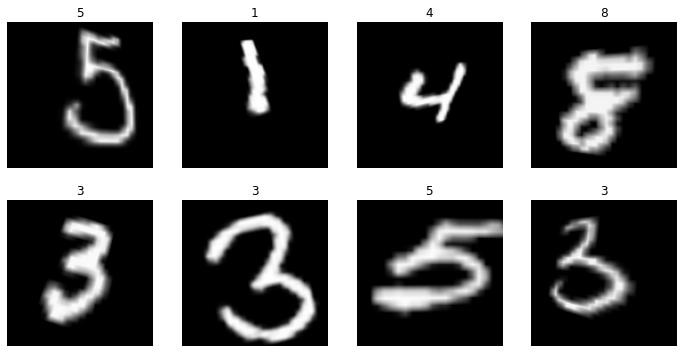

In [12]:

dls.train.show_batch(max_n=8, nrows=2)


Yup, that's it! That's all you have to do to have a look at your batch of data.

We can see that our images look slightly distorted, and this is what we call as **Data Augmentation**, which transforms your images to make it harder for the model to identify, but in practice, makes your model more robust to a variety of inputs. It also obviously solves the problem of lack of training data as now we can create multiple training images from what was initially a single given traning example.

## Training our model

Now that we have our `DataLoaders` ready, we're finally ready to code up our model. But first, we need to decide which model we want to use.

Back in the day, for any type of classification problem, we would look into models like **Logistic Regression**, **Random Forests**, **Multi-layer Perceptrons**, etc. These models would perform great on tabular data, but in this case we're dealing with image data. To use these models with image data, we had to flatten the image pixels into a single vector, which represented the whole image, and was put into these models.

The issue with this is that, even though models like **Multi-layer Perceptrons** have given great results in the past, our input is still linear, and hence the model fails to learn certain features of the image which is lost by flattening the pixel values.

Then in the 1990's, came the first modern use of Convolutional Neural Networks, abbreviated as CNNs, by Yann LeCun et al. in their paper, [“Gradient-Based Learning Applied to Document Recognition”](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) where they used this very MNIST dataset!

Now, going into understanding CNNs is a whole another blog post in itself and there are so many of them out there on the Internet. Hence, I wont be covering this topic in this tutorial, but here's a [blog post](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/#:~:text=Convolutional%20Neural%20Networks%20(ConvNets%20or,robots%20and%20self%20driving%20cars.) I love, explaining how CNNs work in very detail!

But to give you a high-level idea of CNNs, they basically run filters, which have certain weights associated with them, over an image to determine the various features of the image.

IMAGE

In this tutorial, we'll be using a CNN called **[Resnets](https://arxiv.org/abs/1512.03385)**, which comes pretrained on the [ImageNet dataset](http://www.image-net.org/). By **pretrained**, what I mean is that, this model was trained on the mentioned ImageNet dataset, and then the weights of that model were saved, and now used by Deep Learning lovers all around the world!

> Note: This method of using a pretrained model is called **Transfer Learning**, and I would recommend reading about it once you have a good understanding of CNNs.

Fastai makes transfer learning with well-known models like Resnets, super easy with their `cnn_learner` function, which returns a Learner object. To know more about this, feel free to refer the [docs](https://docs.fast.ai). Basically, a Learner object contains the model, along with features such as plotting losses, printing accuracies as we train, etc. So now, we'll define our `cnn_learner`.

In [21]:
learn = cnn_learner(dls, resnet18, pretrained=True, metrics=accuracy)

Guess what? You have a state-of-the-art model ready to train on your data, in just a single line of code!

> Tip: To have a look at how the model is defined, try running `learn.model` in a code cell.

Now if you're familiar with Backpropagation and Gradient Descent, you might know what a **Learning Rate** is. It is basically a ***hyper-parameter*** that lets you decide how fast your model will learn. But you need to be careful deciding its value, as a value too high or too low, will lead to your model failing to learn properly.

To help you decide a good learning rate, the `Learner` object comes with this function, `Learner.lr_find()` which basically runs the training process, which inclues Backpropagation, Gradient Descent, etc, but with the learning rate increasing as it trains. This Learning Rate finder method was introduced by Leslie Smith, in her paper, [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf).

So let's go ahead and find a good learning rate to train our model!

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.007585775572806597)

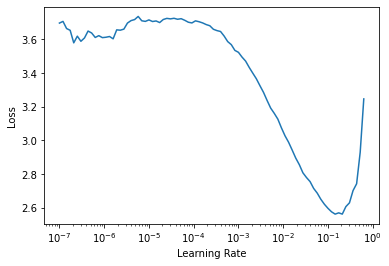

In [22]:
learn.lr_find()

As we see here, a graph of **Loss** against **Learning Rate** is plotted. Usually it is suggested to use a learning rate where the curve is **steepest** since that's where the model seems to be learning the fastest. One would say why not use the learning rate where loss is **minimum**, but if you look at the curve, the curve becomes increasing right after its minimum point, and hence the once you start training, the model will start getting worse within a few epochs. 

Hence, we'll go ahead with a learning rate of `7e-3`

In [23]:
learn.fine_tune(5, lr=7e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.582411,0.171095,0.947000,03:25


epoch,train_loss,valid_loss,accuracy,time
0,0.124255,0.035682,0.988214,03:51
1,0.094673,0.021345,0.993357,03:53
2,0.062400,0.021696,0.993714,03:55
3,0.043637,0.014921,0.995643,03:59
4,0.041164,0.013886,0.996214,03:58


With that, we just trained a resnet on out training data and got an accuracy of pretty much **100%** in just around **20 mins!** (which could be even lesser if you use Colab or have a better GPU than mine)

One thing I would like to mention is the function `fine_tune` that we ran for this model. Since we're using a pretrained model, how Transfer Learning works is that, apart from the final layer of the model, which allows us to classify, the rest of the model is initially **freezed**. Frozen layers mean they are not trained and hence their weights are not updated. 

Hence, how `fine_tune` works is that, it first runs one epoch with only the final layer **not** frozen, and then runs the number of epochs specified by you, with the whole model **not** frozen.

Now all that's left to do is to save our model, or rather ***export*** our model, which we can do with the following line of code:

In [ ]:
learn.export(fname='mnist_resnet18.pkl')

With that, we just saw how we go about loading our data, creating `DataBlocks`, `DataLoaders` and `Datasets`, loading our model, pretraining it, and then finally exporting it! 

To learn more about this whole process, do check out the [fastai course](https://course.fast.ai)!

Now we can move on to creating our API with FastAPI!